# 5.2 Fit of the Crab Nebula gamma-ray spectrum

In the last notebook, we have extracted counts vs energy, but this is a physical quantity (or information) filtered through our detector system. What we really aim at estimating is the gamma-ray flux of the source. As we can measure the flux over a large band in energy, we usually measure the spectrum, the flux vs energy.

In [1]:
# basic imports
import numpy as np
import astropy.units as u
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Image

# Gammapy imports
from gammapy.datasets import SpectrumDatasetOnOff, Datasets
from gammapy.modeling import Parameter
from gammapy.modeling.models import (
    SpectralModel,
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    SkyModel,
    create_crab_spectral_model,
)
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator

Gammapy support for parallelisation with ray is still a prototype and is not fully functional.


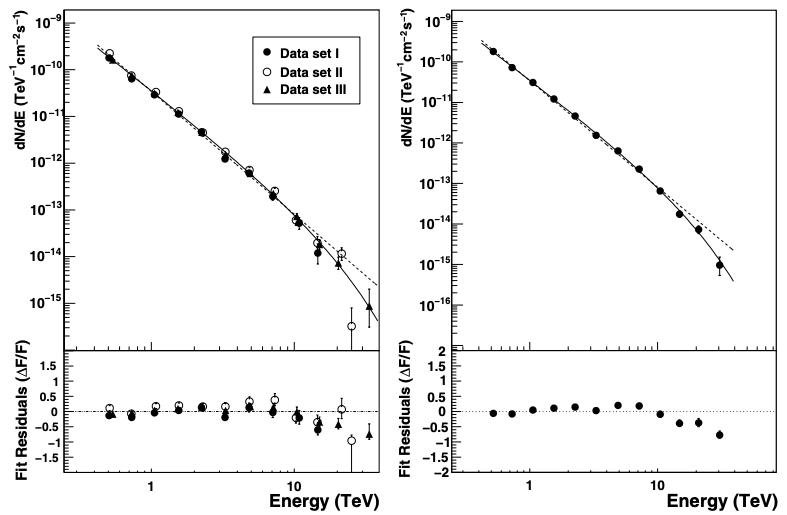

In [2]:
Image("../figures/crab_sed_hess.png")

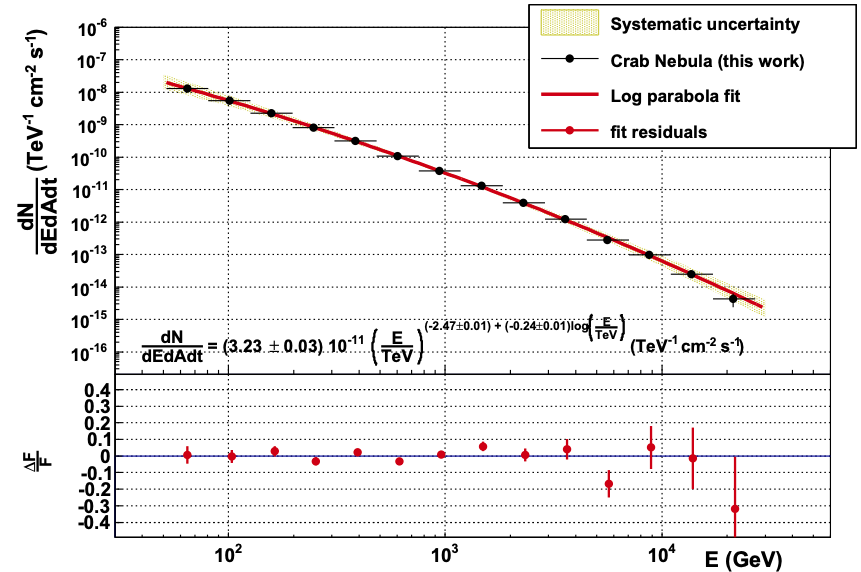

In [3]:
Image("../figures/crab_sed_magic.png", width=800)

It is commonly assumed that a simple analytical function describes the gamma-ray (differential) flux vs energy. The most common example is a power-law (we will see in tomorrow's lecture where power-law of photons come from):

$$
\frac{{\rm d}\phi}{{\rm d}E}(E; \Phi_0, \Gamma, E_0)\,[{\rm TeV}^{-1}\,{\rm cm}^{-2}\,{\rm s}^{-1}] = 
\Phi_0 \left(\frac{E}{E_0}\right)^{-\Gamma}.
$$

Note that we have a continuous dependency on the energy (we want to measure the flux as a function of the energy) and we have a (parametric) dependency on few parameters that describe our analytical spectrum, in this case the normalisation $\Phi_0$, the reference energy, $E_0$, and the spectral index, $\Gamma$. From now on, we will represent all the model parameters with an array $\hat{\theta}$.

Let us now plot some of the examples of analytical spectra available in `Gammapy`:

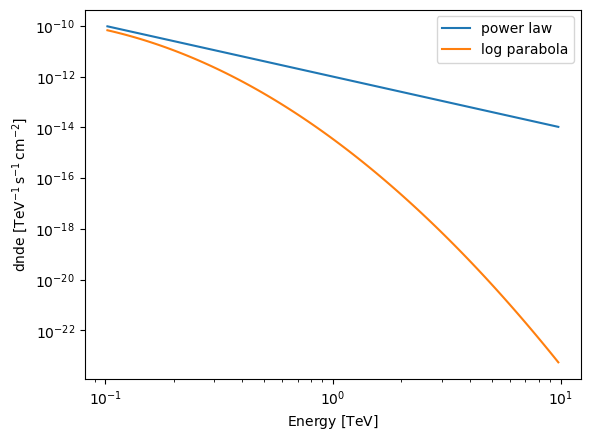

In [4]:
energy_bounds = [100 * u.GeV, 10 * u.TeV]
pwl = PowerLawSpectralModel()
pwl.plot(energy_bounds, label="power law")
lp = LogParabolaSpectralModel(
    amplitude=7e-11 * u.Unit("TeV-1 cm-2 s-1"), reference=100 * u.GeV
)
lp.plot(energy_bounds, label="log parabola")
plt.legend()
plt.show()

How can we adjust the parameters $\hat{\theta}$ of the analytical spectrum to the counts that we have extracted? That's where the IRF come into place. The IRF allow us to go from gamma-ray flux to instrument counts and vice versa. By folding (i.e. convolving) the analytical flux model with the response of the system we can obtain counts vs energy. We basically transform the absolute flux quantity relative to the detector. THe number of model (or _predicted_) counts in a given energy bin $\Delta E_{\rm est}$ is:

$$
g_{i}(\hat{\theta}) = 
    t_{\rm eff} \int_{\Delta E_{\rm est}} {\rm d}E_{\rm est} \int_{0}^{\infty} {\rm d}E_{\rm true}
    A_{\rm eff}(E_{\rm true}) M(E_{\rm est}|E_{\rm true}) \frac{{\rm d}\phi}{{\rm d}E}(E; \hat{\theta}),
$$

where $A_{\rm eff}(E_{\rm true})$ represent the effective area and $M(E_{\rm est}|E_{\rm true})$ the energy dispersion, i.e. the PDF of the energy estimator.

How we decide which (predicted) counts better describe our model? With a likelihood, we assume that the counts in each bin are described by Poissonian statistics. The total likelihood for our dataset, accounting for the observed and estimated counts in each energy bin, reads:

$$ 
\mathcal{L}(\hat{\theta}) = 
    \Pi_{i=1}^{N} {\rm Pois}(g_i(\hat{\theta}) + b_i; N_{{\rm ON}, i}) {\rm Pois}(b_i / \alpha; N_{{\rm OFF}, i})
$$

where $b_i$ is the number of predicted counts, $\alpha$ the ratio between the on and off region exposures. $b_i$ is typically treated as a nuisance parameter. The likelihood is maximised by varying the spectral parameters $\theta$, and hence the number of predicted counts.

## 5.2.1 Predicting the counts for a given data set
Let us load the data sets we created in the previous notebook.

In [5]:
# H.E.S.S. and MAGIC run numbers
obs_ids_hess = [23523, 23526, 23559, 23592]
obs_ids_magic = [5029747, 5029748]

# H.E.S.S. and MAGIC fit energy ranges
e_min_magic = 0.08 * u.TeV
e_max_magic = 10 * u.TeV
e_min_hess = 0.66 * u.TeV
e_max_hess = 30 * u.TeV

# load the spectral files (i.e. on and off counts and IRF) we extracted in the previous notebooks
datasets = Datasets()

# load H.E.S.S. spectral datasets
for obs_id in obs_ids_hess:
    dataset = SpectrumDatasetOnOff.read(f"results/spectra/hess/pha_obs_{obs_id}.fits")
    # set the proper energy ranges
    dataset.mask_fit = dataset.counts.geom.energy_mask(e_min_hess, e_max_hess)
    datasets.append(dataset)


# load MAGIC spectral datasets
for obs_id in obs_ids_magic:
    dataset = SpectrumDatasetOnOff.read(f"results/spectra/magic/pha_obs_{obs_id}.fits")
    # set the proper energy ranges
    dataset.mask_fit = dataset.counts.geom.energy_mask(e_min_magic, e_max_magic)
    datasets.append(dataset)

In [6]:
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 23523
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 23526
  Instrument : 
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 23559
  Instrument : 
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 23592
  Instrument : 
  Models     : 

Dataset 4: 

  Type       : SpectrumDatasetOnOff
  Name       : 5029747
  Instrument : 
  Models     : 

Dataset 5: 

  Type       : SpectrumDatasetOnOff
  Name       : 5029748
  Instrument : 
  Models     : 




once we have the data sets we can specify a model for them, `Gammapy` will automatically convolve it with the response of the system and compute (predict) the counts. Here an example.

In [7]:
# define the model to be fitted
spectral_model = LogParabolaSpectralModel(
    amplitude=1e-12 * u.Unit("TeV-1 cm-2 s-1"),
    reference=1 * u.TeV,
    alpha=2.3 * u.Unit(""),
    beta=0.1 * u.Unit(""),
)

model = SkyModel(spectral_model=spectral_model, name="CrabNebula")

datasets.models = [model]

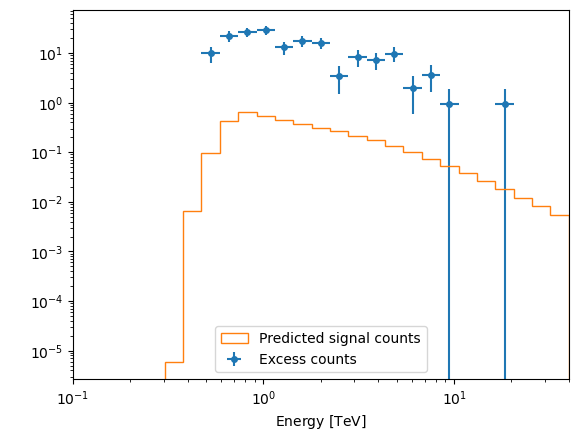

In [8]:
datasets[0].plot_excess()
plt.show()

We can also check the contribution of this data set to the total likelihood.

In [9]:
datasets[0].stat_sum()

394.0342454343004

As we can see, the counts predicted by the model we specified for the data set are one order of magnitude below the observed source counts. 

To get a feeling of how the fit work, go back to the definition of the spectral analytical function and change the amplitude parameter to `5e-11 * u.Unit("TeV-1 cm-2 s-1")`. What happens to the predicted counts? And what happens to the likelihood statistics? 

You have now an intuition of how the fitting routine work. The parameters will be changed until the best match between observed and predicted counts is observed. This agreement is statistically quantified by the likelihood, which is what is actually maximised.

## 5.2.2 Spectrum of the Crab Nebula as seen by the H.E.S.S. and MAGIC telescopes
The likelihood maximisation is performed by the `gammapy.Fit` class suing the `gammapy.Dataset` and the model we have attached to it.

In [10]:
# run it
fit = Fit()
results = fit.run(datasets=datasets)
print(results)

/Users/cosimo/software/mambaforge/envs/gammapy-dev/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cosimo/software/mambaforge/envs/gammapy-dev/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cosimo/software/mambaforge/envs/gammapy-dev/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cosimo/software/mambaforge/envs/gammapy-dev/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cosimo/software/mambaforge/envs/gammapy-dev/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encoun

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 203
	total stat : 104.65

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



We can check, after the optimisation, how the predicted counts adapt to the observed one

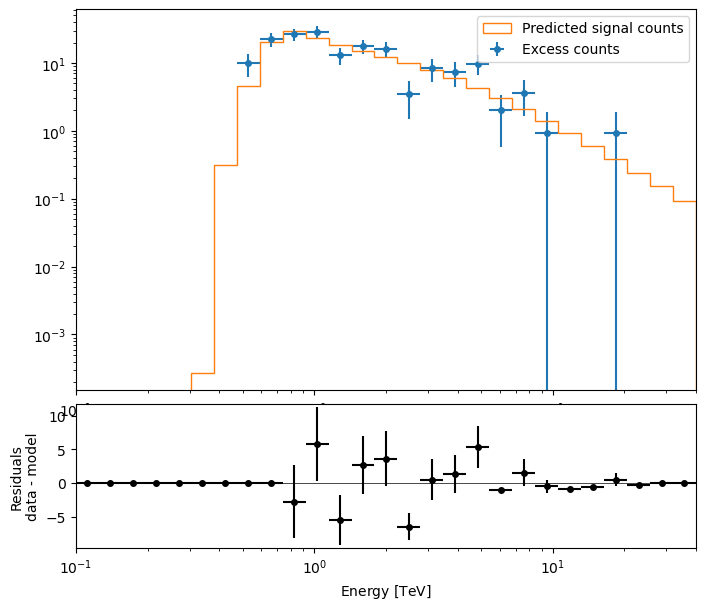

In [11]:
ax_spectrum, ax_residuals = datasets[0].plot_fit()
plt.show()

and check also the value of the likelihood per each of the data sets.

In [12]:
datasets[0].stat_sum()

20.35290478098198

We can now plot the spectrum obtained by our fitting procedure. It is common in high-energy astronomy to represent instead of the differential flux the Spectral Energy Distribution (SED) obtained as $E^2\frac{{\rm d}\phi}{{\rm d}E} [{\rm TeV}^{-1}\,{\rm cm}^{-2}\,{\rm s}^{-1}]$ that represent the power emitted over the unit surface. We compare the results we have obtained with a theoretical model of the SED and with another measurement performed by MAGIC.

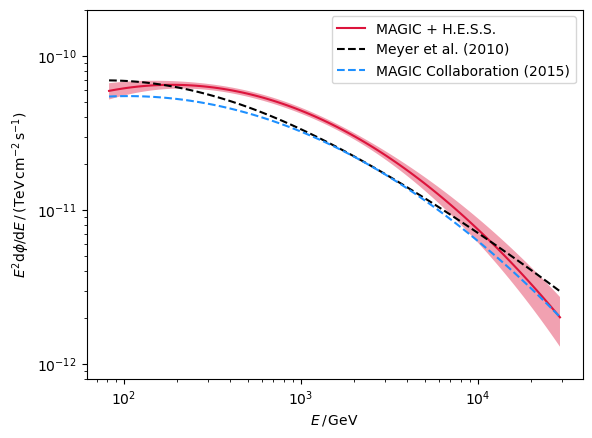

In [13]:
fig, ax = plt.subplots()

plot_kwargs = {
    "sed_type": "e2dnde",
    "yunits": u.Unit("TeV cm-2 s-1"),
    "xunits": u.GeV,
}

spectral_model.plot(
    [80 * u.GeV, 30 * u.TeV],
    ax=ax,
    color="crimson",
    ls="-",
    label="MAGIC + H.E.S.S.",
    **plot_kwargs,
)
spectral_model.plot_error(
    [80 * u.GeV, 30 * u.TeV], ax=ax, facecolor="crimson", alpha=0.4, **plot_kwargs
)

crab_meyer = create_crab_spectral_model("meyer")
crab_meyer.plot(
    [80 * u.GeV, 30 * u.TeV],
    ax=ax,
    label="Meyer et al. (2010)",
    color="k",
    ls="--",
    **plot_kwargs,
)

crab_magic = create_crab_spectral_model("magic_lp")
crab_magic.plot(
    [80 * u.GeV, 30 * u.TeV],
    ax=ax,
    label="MAGIC Collaboration (2015)",
    color="dodgerblue",
    ls="--",
    **plot_kwargs,
)

ax.legend()

ax.set_xlabel(r"$E\,/\,{\rm GeV}$")
ax.set_ylabel(
    r"$E^2 {\rm d}\phi/{\rm d}E\,/\,({\rm TeV}\,{\rm cm}^{-2}\,{\rm s}^{-1})$"
)
ax.set_ylim([8e-13, 2e-10])
plt.show()

# Exercises  Section 5.2:

## Exercise 5.2.1
Obtain an estimate of the Crab Spectrum with the H.E.S.S. and MAGIC data sets separately. Then produce a plot of the spectrum obtain with the H.E.S.S. data, with the MAGIC data, and with the joint dataset.